In [1]:
#import required classes and packages
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical 
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling2D, BatchNormalization
from keras.layers import Convolution2D
from keras.models import Sequential, load_model, Model
import pickle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV #grid class for tuning each algorithm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
from keras.applications import VGG16

In [2]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Brain Tumor Class Labels Found in Dataset: "+str(labels)) 

Brain Tumor Class Labels Found in Dataset: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [5]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                img = cv2.resize(img, (32, 32))#resize image
                X.append(img) #add image pixels to X array
                label = getLabel(name)#get image label id
                Y.append(label)#add image label                
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 2870



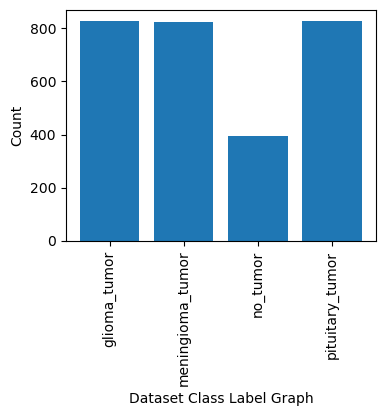

In [6]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Sample Processed Image')

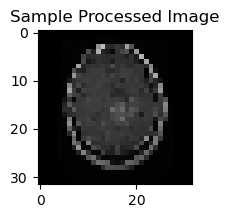

In [7]:
#display processed sample image
img = X[0]
plt.figure(figsize =(2, 2)) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Processed Image")

In [8]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 2296
20% image used to train algorithms : 574


In [9]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [10]:
#function to calculate accuracy and other metrics
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

Tuned KNN Accuracy  :  77.17770034843205
Tuned KNN Precision : 78.13053215825457
Tuned KNN Recall    : 74.51799287467989
Tuned KNN FScore    : 75.28338160357431


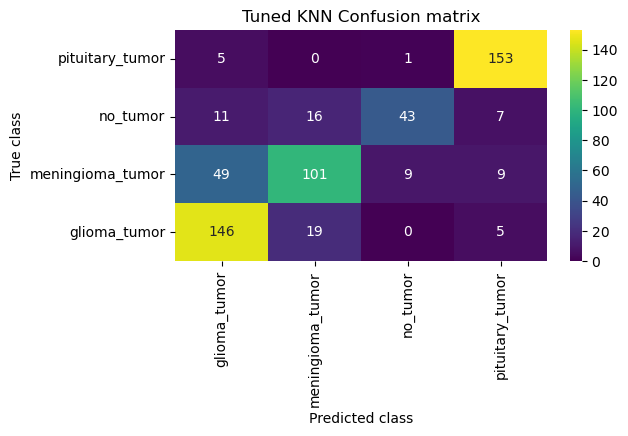

In [11]:
#training KNN algorithm with tuning parameters 
X_train1 = np.reshape(X_train, (X_train.shape[0], (X_train.shape[1] * X_train.shape[2] * X_train.shape[3])))  
X_test1 = np.reshape(X_test, (X_test.shape[0], (X_test.shape[1] * X_test.shape[2] * X_test.shape[3])))  
y_test1 = np.argmax(y_test, axis=1)
y_train1 = np.argmax(y_train, axis=1)
X_train1 = X_train1[0:1000]
y_train1 = y_train1[0:1000]
tuning_param = {'n_neighbors' : [2, 3, 5], 'p' : [1]}
knn_cls = GridSearchCV(KNeighborsClassifier(), tuning_param, cv=5)#defining knn with tuned parameters
knn_cls.fit(X_train1, y_train1)#now train KNN with tuning params
predict = knn_cls.predict(X_test1) #perfrom prediction on test data
#call this function to calculate accuracy and other metrics
calculateMetrics("Tuned KNN", predict, y_test1)

Tuned Random Forest Accuracy  :  82.92682926829268
Tuned Random Forest Precision : 83.16601158079625
Tuned Random Forest Recall    : 82.47837900168643
Tuned Random Forest FScore    : 82.60266016513616


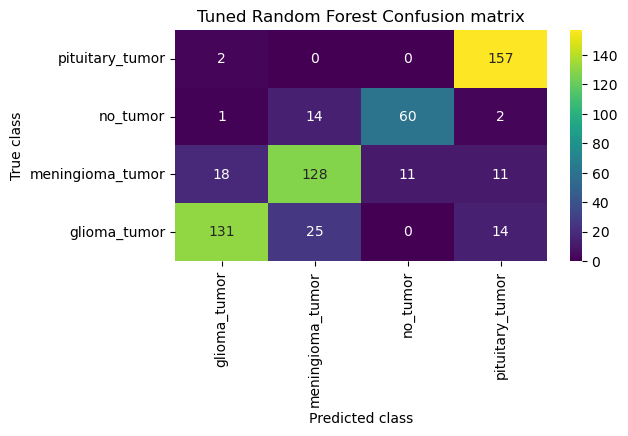

In [12]:
#training tuned Random Forest algorithm
tuning_param = {'n_estimators' : [50, 100, 150], 'max_depth': [5, 10, 15]}
rf_cls = GridSearchCV(RandomForestClassifier(), tuning_param, cv=5)#defining Random Forest with tuned parameters
rf_cls.fit(X_train1, y_train1)#now train Random Forest
predict = rf_cls.predict(X_test1) #perfrom prediction on test data
#call this function to calculate accuracy and other metrics
calculateMetrics("Tuned Random Forest", predict, y_test1)

Tuned SVM Accuracy  :  77.87456445993031
Tuned SVM Precision : 79.35617229221434
Tuned SVM Recall    : 76.39757232223936
Tuned SVM FScore    : 77.36494487786115


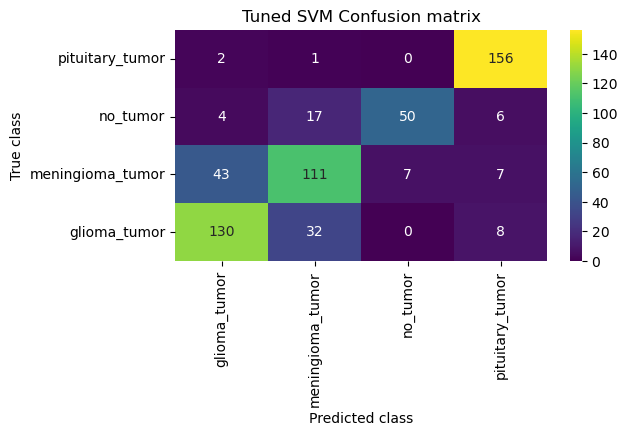

In [13]:
#training tuned SM algorithm
#defining SVM tuning parameters
tuning_param = {'C' : [2, 3, 5], 'kernel': ['linear', 'rbf']}
svm_cls = GridSearchCV(svm.SVC(), tuning_param, cv=5)
svm_cls.fit(X_train1, y_train1)#now train SVM
predict = svm_cls.predict(X_test1) #perfrom prediction on test data
#call this function to calculate accuracy and other metrics
calculateMetrics("Tuned SVM", predict, y_test1)

C:\Users\sahit\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4818 - loss: 1.2332
Epoch 1: val_loss improved from inf to 0.99926, saving model to model\cnn_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.4842 - loss: 1.2275 - val_accuracy: 0.5314 - val_loss: 0.9993
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6351 - loss: 0.8811
Epoch 2: val_loss improved from 0.99926 to 0.88315, saving model to model\cnn_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6353 - loss: 0.8803 - val_accuracy: 0.6533 - val_loss: 0.8831
Epoch 3/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6806 - loss: 0.7605
Epoch 3: val_loss improved from 0.88315 to 0.72157, saving model to model\cnn_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6820 - loss: 0.7583 - val_accuracy: 0.6864 - val_loss: 0.7216
Epoch 4/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7527 - loss: 0.6044
Epoch 4: val_loss improved from 0.72157 

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9969 - loss: 0.0324
Epoch 25: val_loss did not improve from 0.47151
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9969 - loss: 0.0323 - val_accuracy: 0.8380 - val_loss: 0.5909
Epoch 26/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9972 - loss: 0.0298
Epoch 26: val_loss did not improve from 0.47151
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9973 - loss: 0.0296 - val_accuracy: 0.8484 - val_loss: 0.5779
Epoch 27/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9997 - loss: 0.0176
Epoch 27: val_loss did not improve from 0.47151
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9997 - loss: 0.0176 - val_accuracy: 0.8467 - val_loss: 0.5830
Epoch 28/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0149
Epoch 28: val_loss did not improve from 0.47151
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 0.8449 - val_loss: 0.5921
Epoch 29/60


Epoch 51/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 51: val_loss did not improve from 0.47151
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8484 - val_loss: 0.7738
Epoch 52/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 52: val_loss did not improve from 0.47151
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8380 - val_loss: 0.7914
Epoch 53/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 53: val_loss did not improve from 0.47151
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8484 - val_loss: 0.7837
Epoch 54/60
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 54: val_loss did not improve from 0.47151
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8502 - val_loss: 0.7945


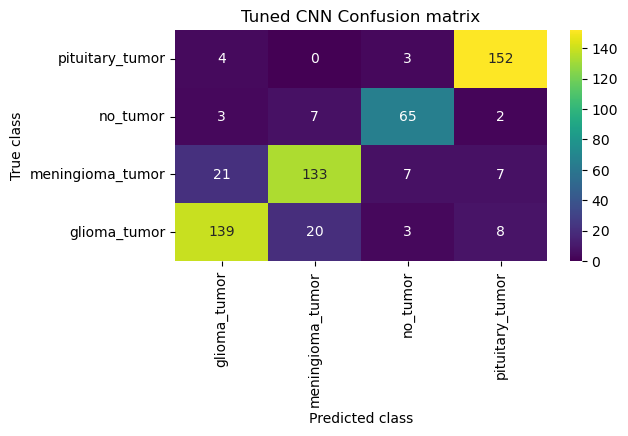

In [14]:
#training CNN algorithm by usig different layers with tuning values
cnn_model = Sequential()
#defining CNN layer with 32 neurons of size 3 X 3 to filter image features 32 times
cnn_model.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#defining max pool layer to collect filtered relevant features from CNN layer
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
#defining another CNN layer to further optimized features
cnn_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
#maxpool collect optimized features from CNN
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
#convert multi dimension features to single dimension features
cnn_model.add(Flatten())
#defining output prediction Dense layer
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compiling, training and loading model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath=os.path.join('model', 'cnn_weights.keras'), verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train, y_train, batch_size = 64, epochs = 60, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data   
predict = cnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#call this function to calculate accuracy and other metrics
calculateMetrics("Tuned CNN", predict, y_test1)

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.3800 - loss: 1.3054
Epoch 1: val_loss improved from inf to 0.94723, saving model to model\vgg_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 816ms/step - accuracy: 0.3820 - loss: 1.3022 - val_accuracy: 0.5854 - val_loss: 0.9472
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.5880 - loss: 0.9488
Epoch 2: val_loss improved from 0.94723 to 0.83735, saving model to model\vgg_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 768ms/step - accuracy: 0.5881 - loss: 0.9483 - val_accuracy: 0.6533 - val_loss: 0.8373
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6433 - loss: 0.8496
Epoch 3: val_loss improved from 0.83735 to 0.79070, saving model to model\vgg_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 786ms/step - accuracy: 0.6431 - loss: 0.8498 - val_accuracy: 0.6760 - val_loss: 0.7907
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.6557 - loss: 0.7971
Epoch 4: val_loss improved fro

Epoch 24/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.7962 - loss: 0.5053
Epoch 24: val_loss did not improve from 0.51511
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 723ms/step - accuracy: 0.7962 - loss: 0.5052 - val_accuracy: 0.7875 - val_loss: 0.5378
Epoch 25/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.7978 - loss: 0.4798
Epoch 25: val_loss improved from 0.51511 to 0.50475, saving model to model\vgg_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 674ms/step - accuracy: 0.7979 - loss: 0.4796 - val_accuracy: 0.7962 - val_loss: 0.5048
Epoch 26/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.7996 - loss: 0.4843
Epoch 26: val_loss did not improve from 0.50475
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 890ms/step - accuracy: 0.7997 - loss: 0.4843 - val_accuracy: 0.8031 - val_loss: 0.5122
Epoch 27/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8164 - loss: 0.4509
Epoch 27: val_loss improved from 0.50475 to 0.50247, saving model to model\vgg_weights.keras
36/36 ━━━━━━━━━━

Epoch 48/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.8571 - loss: 0.3545
Epoch 48: val_loss did not improve from 0.46263
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 812ms/step - accuracy: 0.8570 - loss: 0.3548 - val_accuracy: 0.8118 - val_loss: 0.4699
Epoch 49/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8757 - loss: 0.3324
Epoch 49: val_loss improved from 0.46263 to 0.46038, saving model to model\vgg_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 883ms/step - accuracy: 0.8754 - loss: 0.3329 - val_accuracy: 0.8188 - val_loss: 0.4604
Epoch 50/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8617 - loss: 0.3495
Epoch 50: val_loss improved from 0.46038 to 0.45252, saving model to model\vgg_weights.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 810ms/step - accuracy: 0.8617 - loss: 0.3495 - val_accuracy: 0.8240 - val_loss: 0.4525
Epoch 51/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.8415 - loss: 0.3639
Epoch 51: val_loss did not improve from 0.45252
36/36 ━━━━━━━━━━

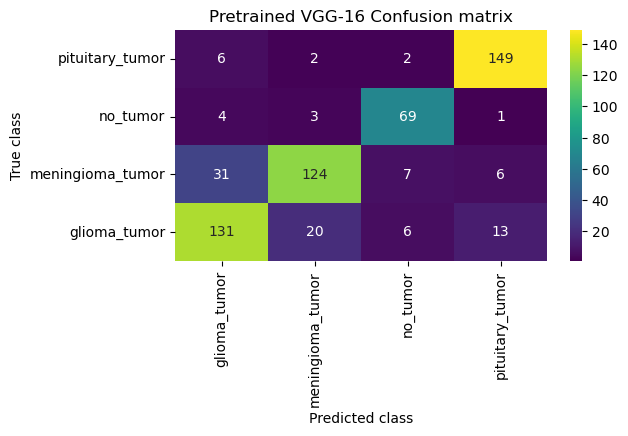

In [15]:
#initializing pretrained VGG16 algorithm
vgg16 = VGG16(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in vgg16.layers:
    layer.trainable = False
#now utilizing VGG16 as transfer learning to predict eye diseases    
baseModel = vgg16.output
baseModel = AveragePooling2D(pool_size=(1, 1))(baseModel)
baseModel = Flatten(name="flatten")(baseModel)
baseModel = Dense(256, activation="relu")(baseModel)
baseModel = Dropout(0.5)(baseModel)
baseModel = Dense(y_train.shape[1], activation="softmax")(baseModel)
vgg16_model = Model(inputs=vgg16.input, outputs=baseModel)
vgg16_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#densenet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/vgg_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath=os.path.join('model', 'vgg_weights.keras'), verbose = 1, save_best_only = True)
    hist = vgg16_model.fit(X_train, y_train, batch_size = 64, epochs = 60, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/vgg_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    vgg16_model.load_weights("model/vgg_weights.hdf5")
#perform prediction on test images
predict = vgg16_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#call this function to calculate accuracy and other metrics
calculateMetrics("Pretrained VGG-16", predict, y_test1)

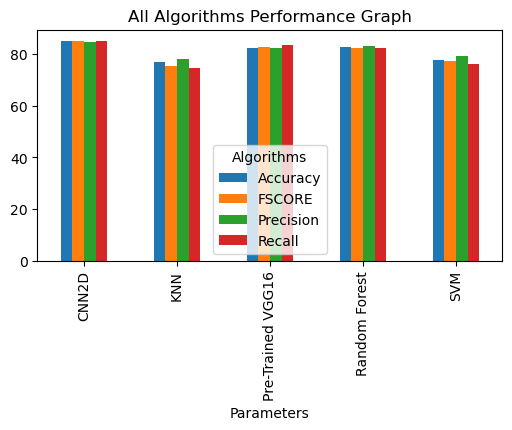

In [16]:
#plot all algorithm performance in tabular format
import pandas as pd
df = pd.DataFrame([['KNN','Accuracy',accuracy[0]],['KNN','Precision',precision[0]],['KNN','Recall',recall[0]],['KNN','FSCORE',fscore[0]],
                   ['Random Forest','Accuracy',accuracy[1]],['Random Forest','Precision',precision[1]],['Random Forest','Recall',recall[1]],['Random Forest','FSCORE',fscore[1]],
                   ['SVM','Accuracy',accuracy[2]],['SVM','Precision',precision[2]],['SVM','Recall',recall[2]],['SVM','FSCORE',fscore[2]],
                   ['CNN2D','Accuracy',accuracy[3]],['CNN2D','Precision',precision[3]],['CNN2D','Recall',recall[3]],['CNN2D','FSCORE',fscore[3]],
                   ['Pre-Trained VGG16','Accuracy',accuracy[4]],['Pre-Trained VGG16','Precision',precision[4]],['Pre-Trained VGG16','Recall',recall[4]],['Pre-Trained VGG16','FSCORE',fscore[4]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [23]:

print(f"Length of accuracy: {len(accuracy)}")
print(f"Length of precision: {len(precision)}")
print(f"Length of recall: {len(recall)}")
print(f"Length of fscore: {len(fscore)}")

# All these lengths should be identical.

Length of accuracy: 5
Length of precision: 5
Length of recall: 5
Length of fscore: 5


In [22]:
#display all algorithm performnace
algorithms = ['Tuned KNN', 'Tuned Random Forest', 'Tuned SVM', 'Tuned CNN', 'Pre-Trained VGG16']
data = []
for i in range(5):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,Tuned KNN,77.177700,78.130532,74.517993,75.283382
1,Tuned Random Forest,82.926829,83.166012,82.478379,82.602660
2,Tuned SVM,77.874564,79.356172,76.397572,77.364945
3,Tuned CNN,85.191638,84.908174,85.236110,85.036009
4,Pre-Trained VGG16,82.404181,82.423201,83.547357,82.852392


In [24]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = cnn_model.predict(img)#now predict dog breed
    predict = np.argmax(predict)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (700,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict], (10, 75),  cv2.FONT_HERSHEY_SIMPLEX,1.4, (0, 255, 0), 2)
    plt.figure(figsize=(8,3))
    plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


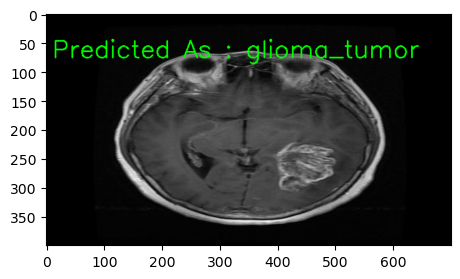

In [25]:
#call this function to predict pupillometry disease with test image path
predict(r"C:\Users\sahit\Downloads\brain-tumor-detection-mri-main\brain-tumor-detection-mri-main\notebooks\Dataset\glioma_tumor\gg (8).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


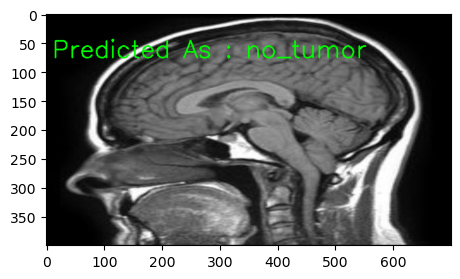

In [27]:
#call this function to predict pupillometry disease with test image path
predict(r"C:\Users\sahit\Downloads\brain-tumor-detection-mri-main\brain-tumor-detection-mri-main\notebooks\Dataset\no_tumor\image(91).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


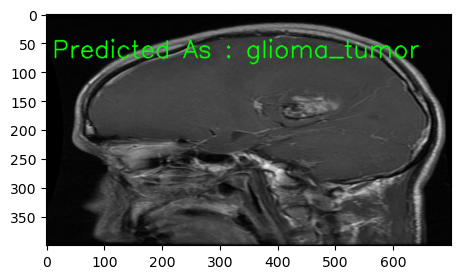

In [29]:
#call this function to predict pupillometry disease with test image path
predict(r"C:\Users\sahit\Downloads\brain-tumor-detection-mri-main\brain-tumor-detection-mri-main\notebooks\Dataset\glioma_tumor\gg (95).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


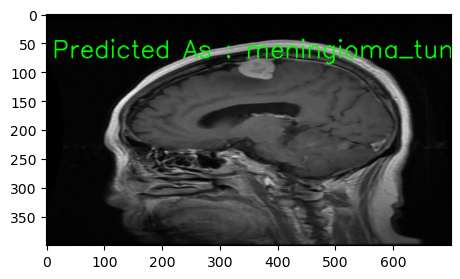

In [31]:
#call this function to predict pupillometry disease with test image path
predict(r"C:\Users\sahit\Downloads\brain-tumor-detection-mri-main\brain-tumor-detection-mri-main\notebooks\Dataset\meningioma_tumor\m3 (28).jpg")